In [1]:
# basic
import os
import warnings
import pickle
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
# NN
import torch
from torch_geometric.utils import dense_to_sparse
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split
# val and plot
from sklearn import preprocessing as pre
from loguru import logger as log
# plot
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [3]:
warnings.filterwarnings('ignore')
plt.style.use('seaborn-whitegrid')
# Generate a sample time series data
np.random.seed(0)

## Load Graph and create adjacente matrix

In [4]:
G = nx.read_gpickle('../../data/graph_designer/graph_gtfs_fev_2024.gpickle')

#### Get nodes with bigger degree

In [5]:
# Get the degree of each node
degrees = dict(G.degree())
# Sort nodes by degree in descending order
sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)
# Get the top N nodes with the highest degrees
top_n = 5  
top_nodes = sorted_degrees[:top_n]
top_nodes

[('44042532', 19),
 ('66292237', 14),
 ('44783362', 13),
 ('43768318', 11),
 ('350375938', 11)]

In [6]:
# get idx tensor for nodes
df_columns_order = pd.read_parquet('../../data/graph_designer/tensor_node_idx.parquet')
df_columns_order_dict = df_columns_order.set_index('sobe')['tensor_idx'].to_dict()

In [7]:
idx_nodes = [df_columns_order_dict[nd[0]] for nd in top_nodes]
idx_nodes

[694, 2772, 1203, 592, 561]

In [8]:
df_nodes_selected = pd.DataFrame(top_nodes, columns=['node', 'degree'])
df_nodes_selected['tensor_idx'] = idx_nodes
df_nodes_selected

,node,degree,tensor_idx
0,44042532,19,694
1,66292237,14,2772
2,44783362,13,1203
3,43768318,11,592
4,350375938,11,561


In [9]:
df_nodes_selected.to_csv('../../data/graph_designer/train_test/df_nodes_selected.csv', index=False)

#### Adjacente matrix

In [10]:
# Get the adjacency matrix (sparse matrix format)
# adj_matrix_sparse = nx.adjacency_matrix(G)

# # Convert the sparse matrix to a dense format (NumPy array)
# #A = adj_matrix_sparse.toarray()
# A = np.mat(adj_matrix_sparse)
# A.shape

In [11]:
A = nx.adjacency_matrix(G, weight='distance')
a_sparse = A.todense()
A = np.mat(a_sparse)
A

matrix([[0.   , 0.254, 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.131, 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [70]:
A.shape

(2871, 2871)

## Join all tensor to create a time series

In [12]:
days = ['01', '02', '03', '04', '05', '06', '07', '08']

In [13]:
def moving_average(tensor, window_size):
    
    A = tensor.shape[0]
    # Initialize the result tensor
    result = np.zeros_like(tensor)
    
    # Pad the array with zeros on the time dimension
    padded_tensor = np.pad(tensor, ((window_size-1, 0), (0, 0), (0, 0)), mode='constant', constant_values=0)
    
    # Calculate the moving average
    for i in range(window_size, A + window_size):
        result[i - window_size] = np.mean(padded_tensor[i - window_size:i], axis=0)
        
    return result

In [14]:
data_faixas, data_features = [], []
for day in days:
    date = f"{day}-03-2024"
    date_folder = f'2024-03-{day}'    
    data_faixas.append(pd.read_parquet(f'../../data/graph_designer/node_temporal_features_{date}.parquet'))
    # features
    nf_time_array = np.load(f'../../data/graph_designer/tensor_node_temporal_features_{date}.npy')
    transposed_array = np.transpose(nf_time_array, (1, 2, 0))

    data_features.append(transposed_array)

In [15]:
# concat days
ssa_bus = pd.concat(data_faixas)
faixas = sorted(ssa_bus.time.unique())
X = np.concatenate(data_features)

In [16]:
X.shape

(1920, 2871, 6)

In [17]:
x_ma = moving_average(X, 12)
x_ma.shape

(1920, 2871, 6)

In [73]:
idx_nodes[1]

2772

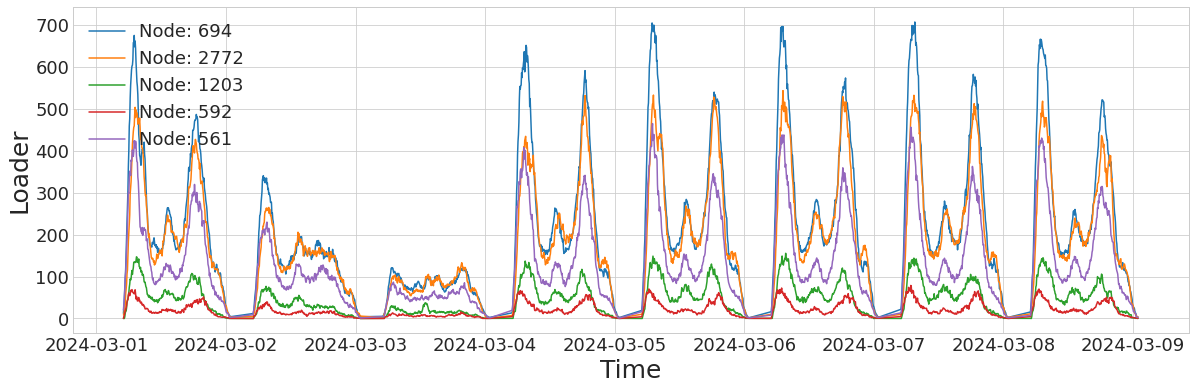

In [77]:
# series usadas para teste
att =  2
plt.figure(figsize=(20, 6))
for node in idx_nodes:
    plt.plot(faixas,  x_ma[:,node, att], label=f'Node: {node}')
plt.xlabel('Time', fontsize=25)
plt.ylabel(f'Loader', fontsize=25)
#plt.title('Time Series and Moving Average')
plt.legend(fontsize=18)
#plt.xticks(pos_dt, labels_time, fontsize=18)  # Increase x-tick font size
plt.yticks(fontsize=18)  # Increase x-tick font size
plt.xticks(fontsize=18)  # I
plt.savefig('ma_nodes_test.png', dpi=300, bbox_inches='tight')
plt.show()

# plt.xlabel('Time', fontsize=25)
# plt.ylabel('Loader', fontsize=25)
# #plt.title(f'Time Series and Forecasting - {model} - {np.mean(df_result.mse.values):.2f}')
# plt.legend(fontsize=18)
# plt.xticks(pos_dt, labels_time, fontsize=18)  # Increase x-tick font size
# plt.yticks(fontsize=18)  # Increase x-tick font size
# plt.savefig('forecasting_all_models.png', dpi=600, bbox_inches='tight')
# plt.show()

In [78]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [82]:
from statsmodels.tsa.stattools import acf

In [85]:
values = acf(x_ma[:,idx_nodes[0], att], nlags=500)

In [91]:
i, e = 200, 300
v = max(values[i:e])

In [92]:
np.where(values[i:e] > 0.677 )

(array([40]),)

In [89]:
#values[123]

0.4462230397116279

In [93]:
values[240]

0.6775163177500745

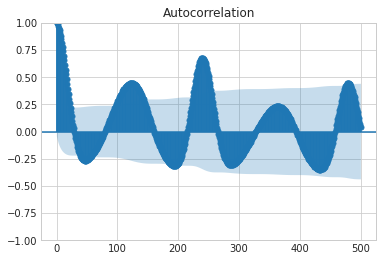

In [81]:
# determinar 
plot_acf(x_ma[:,idx_nodes[0], att], lags=500)
plt.show()

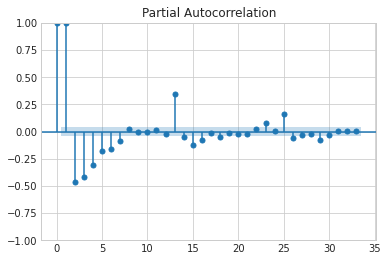

In [80]:
plot_pacf(x_ma[:,idx_nodes[0], att])
plt.show()

In [18]:
atts = {0: 'sobe', 
        1: 'desce', 
        2: 'carregamento', 
        3: 'linha', 
        4: 'trip_id', 
        5: 'tempo_parada'}

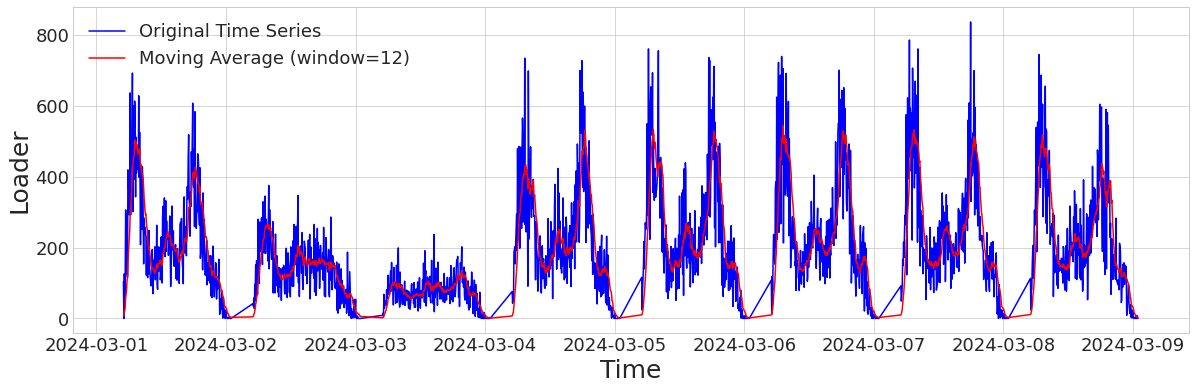

In [68]:
att, node = 2, idx_nodes[1]
plt.figure(figsize=(20, 6))
plt.plot(faixas, X[:,node, att], label='Original Time Series', color='blue')
plt.plot(faixas, x_ma[:,node, att], label=f'Moving Average (window={12})', color='red')
plt.xlabel('Time', fontsize=25)
plt.ylabel(f'Loader', fontsize=25)
#plt.title('Time Series and Moving Average')
plt.legend(fontsize=18)
#plt.xticks(pos_dt, labels_time, fontsize=18)  # Increase x-tick font size
plt.yticks(fontsize=18)  # Increase x-tick font size
plt.xticks(fontsize=18)  # I
plt.savefig('ma_nodes.png', dpi=300, bbox_inches='tight')
plt.show()

# plt.xlabel('Time', fontsize=25)
# plt.ylabel('Loader', fontsize=25)
# #plt.title(f'Time Series and Forecasting - {model} - {np.mean(df_result.mse.values):.2f}')
# plt.legend(fontsize=18)
# plt.xticks(pos_dt, labels_time, fontsize=18)  # Increase x-tick font size
# plt.yticks(fontsize=18)  # Increase x-tick font size
# plt.savefig('forecasting_all_models.png', dpi=600, bbox_inches='tight')
# plt.show()

In [20]:
# fig = go.Figure()

# # Add the original time series
# fig.add_trace(go.Scatter(x=faixas, 
#                          y=X[:,node,att], 
#                          mode='lines', 
#                          name='Original Time Series', 
#                          line=dict(color='blue')))

# # Add the moving average
# fig.add_trace(go.Scatter(x=faixas, 
#                          y=x_ma[:,node,att], 
#                          mode='lines', 
#                          name=f'Moving Average (window={12})', 
#                          line=dict(color='red')))

# # Update the layout
# fig.update_layout(
#     title='Time Series and Moving Average',
#     xaxis_title='Time',
#     yaxis_title=atts[att],
#     #legend=dict(x=0, y=1.0)
# )

# # Save the plot as an HTML file
# #fig.write_html('time_series_and_moving_average.html')

# # Save the plot as a static image (requires Kaleido or Orca)
# # fig.write_image('time_series_and_moving_average.png')  # Uncomment if you have Kaleido or Orca installed

# # Show the plot in an interactive window
# fig.show()

In [21]:
# fig = go.Figure()

# # Add the moving average
# fig.add_trace(go.Scatter(x=faixas, 
#                          y=x_ma[:,node,att], 
#                          mode='lines', 
#                          name=f'Moving Average (window={12})', 
#                          line=dict(color='red')))

# # Update the layout
# fig.update_layout(
#     title='Time Series and Moving Average',
#     xaxis_title='Time',
#     yaxis_title=atts[att],
#     #legend=dict(x=0, y=1.0)
# )

# # Show the plot in an interactive window
# fig.show()

In [22]:
X.shape

(1920, 2871, 6)

In [23]:
x = x_ma.transpose((1, 0, 2))#(1920, 2871, 6)
#x = X.copy()
x = x.astype(np.float32)
x.shape

(2871, 1920, 6)

In [24]:
df_ts = pd.DataFrame({'time': faixas})
df_ts['day'] = df_ts.time.dt.day
df_ts['partition'] = 'train'
df_ts['partition'][df_ts.day >= 8] = 'test'
df_ts['partition_nn'] = 'train'
df_ts['partition_nn'][df_ts.query(" time >= '2024-03-07 09:00:00' ").index] = 'test'
for node in idx_nodes:
    df_ts[f'{atts[att]}_node_{node}'] = x_ma[:, node, att]
df_ts.head()

,time,day,partition,partition_nn,carregamento_node_694,carregamento_node_2772,carregamento_node_1203,carregamento_node_592,carregamento_node_561
0,2024-03-01 05:00:00,1,train,train,12.166667,8.666667,0.000000,0.166667,20.166667
1,2024-03-01 05:05:00,1,train,train,26.583333,8.666667,0.000000,4.833333,32.833333
2,2024-03-01 05:10:00,1,train,train,48.833333,19.166667,0.000000,8.000000,45.916667
3,2024-03-01 05:15:00,1,train,train,76.333333,22.333333,3.916667,12.750000,67.500000
4,2024-03-01 05:20:00,1,train,train,97.250000,33.250000,12.916667,17.250000,97.833333


In [72]:
df_ts.shape

(1920, 9)

In [25]:
df_ts.partition.value_counts(dropna=False)

train    1668
test      252
Name: partition, dtype: int64

In [26]:
df_ts.partition_nn.value_counts(dropna=False)

train    1488
test      432
Name: partition_nn, dtype: int64

In [27]:
df_ts.to_csv('../../data/graph_designer/train_test/df_nodes_selected_loader.csv', index=False)

In [28]:
faixa_train     = df_ts.query(" partition == 'train' ").time
faixa_test      = df_ts.query(" partition != 'train' ").time
faixa_train_nn  = df_ts.query(" partition_nn == 'train' ").time
faixa_test_nn   = df_ts.query(" partition_nn != 'train' ").time

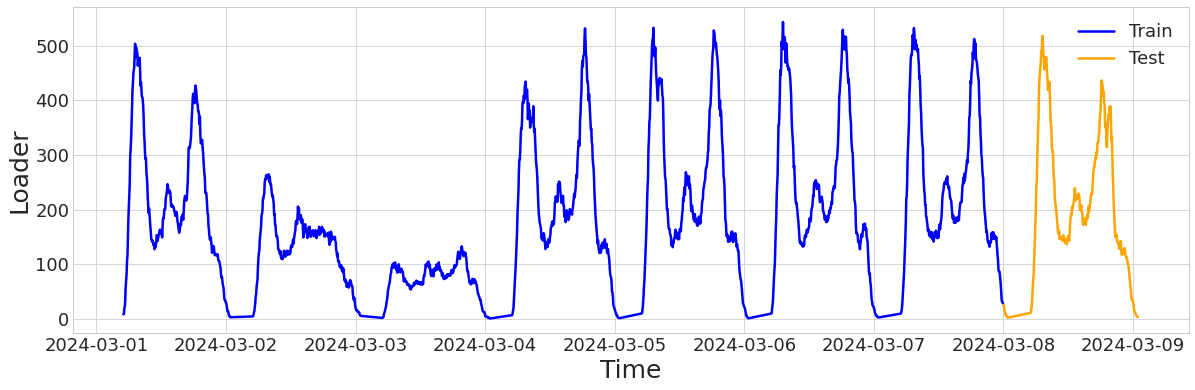

In [64]:
att, node = 2, idx_nodes[1]
plt.figure(figsize=(20, 6))
plt.plot(faixa_train, x_ma[0:len(faixa_train),node, att], label=f'Train', linewidth=2.5, color='blue')
plt.plot(faixa_test, x_ma[len(faixa_train):,node, att], label=f'Test', linewidth=2.5, color='orange')
plt.xlabel('Time', fontsize=25)
#plt.ylabel(f'{atts[att]}', fontsize=18)
plt.ylabel(f'Loader', fontsize=25)
#plt.title('Train and test in time series from one node', fontsize=20)
plt.legend(fontsize=18)
plt.xticks(fontsize=18)  # Increase x-tick font size
plt.yticks(fontsize=18)  # Increase y-tick font size
plt.savefig('time_series_train_test.png', dpi=600, bbox_inches='tight')

plt.show()

In [30]:
#convert to tensorXS = 
A_torch = torch.from_numpy(A)
X_torch = torch.from_numpy(x[:,:,2])
edge_indices, values = dense_to_sparse(A_torch)

In [31]:
X_torch.shape

torch.Size([2871, 1920])

In [32]:
edge_indices = edge_indices.numpy()
values = values.numpy()

edges = edge_indices
edge_weights = values

In [33]:
edge_weights

array([0.254, 0.193, 0.362, ..., 0.263, 0.131, 0.434])

In [34]:
def create_windows(tensor, times, lags, steps):
    indices = [
        (i, i + (lags + steps))
        for i in range(0, tensor.shape[1] - (lags + steps) + 1,  steps)
        #for i in range(0, tensor.shape[1] - (lags + steps) + 1)
    ]
    features, target, ts, ts_train = [], [], [], []
    
    for i, j in indices:
        features.append((tensor[:, i : i + lags]).numpy())
        target.append((tensor[:, i + lags : j]).numpy())
        ts_train.append(times[i : i + lags])
        ts.append(times[i + lags :j])
    
    return features, target, ts_train, ts, indices

In [35]:
X_torch[:,0:len(faixa_train)].shape, X_torch[:,len(faixa_train):].shape

(torch.Size([2871, 1668]), torch.Size([2871, 252]))

In [36]:
tensor_train = X_torch[:,0:len(faixa_train)]
tensor_test  =  X_torch[:,len(faixa_train_nn):]
tensor_train.shape, tensor_test.shape

(torch.Size([2871, 1668]), torch.Size([2871, 432]))

In [37]:
features_train, target_train, tm_train_f, tm_train_t, idxs = create_windows(tensor_train, faixa_train_nn, 36, 12)
features_test, target_test, tm_test_f, tm_test_t, idxs_t = create_windows(tensor_test, faixa_test_nn, 36, 12)

In [38]:
#idxs

In [39]:
dataset_train = StaticGraphTemporalSignal(edge_index=edges, 
                                          edge_weight=edge_weights, 
                                          features=features_train, 
                                          targets=target_train)

In [40]:
dataset_test = StaticGraphTemporalSignal(edge_index=edges, 
                                          edge_weight=edge_weights, 
                                          features=features_test, 
                                          targets=target_test, 
                                          features_time=tm_test_f, 
                                          target_time=tm_test_t)

In [41]:
dataset_train.snapshot_count, dataset_test.snapshot_count

(136, 33)

## Save

In [42]:
fname_train = '../../data/graph_designer/train_test/dataset_train.pkl'
with open(fname_train, 'wb') as f:
    pickle.dump(dataset_train, f)

In [43]:
fname_train = '../../data/graph_designer/train_test/dataset_test.pkl'
with open(fname_train, 'wb') as f:
    pickle.dump(dataset_test, f)

In [44]:
#tm_test_f[0]
tm_train_f[-1]

Series([], Name: time, dtype: datetime64[ns])

In [45]:
#tm_test_t[0]
tm_train_t[-1]

Series([], Name: time, dtype: datetime64[ns])

In [46]:
tm_test_t[0]

1524   2024-03-07 12:00:00
1525   2024-03-07 12:05:00
1526   2024-03-07 12:10:00
1527   2024-03-07 12:15:00
1528   2024-03-07 12:20:00
1529   2024-03-07 12:25:00
1530   2024-03-07 12:30:00
1531   2024-03-07 12:35:00
1532   2024-03-07 12:40:00
1533   2024-03-07 12:45:00
1534   2024-03-07 12:50:00
1535   2024-03-07 12:55:00
Name: time, dtype: datetime64[ns]

In [47]:
tm_test_f[0]

1488   2024-03-07 09:00:00
1489   2024-03-07 09:05:00
1490   2024-03-07 09:10:00
1491   2024-03-07 09:15:00
1492   2024-03-07 09:20:00
1493   2024-03-07 09:25:00
1494   2024-03-07 09:30:00
1495   2024-03-07 09:35:00
1496   2024-03-07 09:40:00
1497   2024-03-07 09:45:00
1498   2024-03-07 09:50:00
1499   2024-03-07 09:55:00
1500   2024-03-07 10:00:00
1501   2024-03-07 10:05:00
1502   2024-03-07 10:10:00
1503   2024-03-07 10:15:00
1504   2024-03-07 10:20:00
1505   2024-03-07 10:25:00
1506   2024-03-07 10:30:00
1507   2024-03-07 10:35:00
1508   2024-03-07 10:40:00
1509   2024-03-07 10:45:00
1510   2024-03-07 10:50:00
1511   2024-03-07 10:55:00
1512   2024-03-07 11:00:00
1513   2024-03-07 11:05:00
1514   2024-03-07 11:10:00
1515   2024-03-07 11:15:00
1516   2024-03-07 11:20:00
1517   2024-03-07 11:25:00
1518   2024-03-07 11:30:00
1519   2024-03-07 11:35:00
1520   2024-03-07 11:40:00
1521   2024-03-07 11:45:00
1522   2024-03-07 11:50:00
1523   2024-03-07 11:55:00
Name: time, dtype: datetime6

In [53]:
edge_attr = torch.tensor([
    [0.5],
    [1.0],
    [1.5],
    [2.0],
    [2.5]
], dtype=torch.float)


In [54]:
edge_attr.shape

torch.Size([5, 1])